O capítulo 15 introduz os **autoencoders**, que são redes neurais artificiais capazes de aprender representações eficientes de dados de entrada, conhecidas como **codings**, sem a necessidade de dados rotulados (aprendizagem não supervisionada). A principal ideia por trás de um autoencoder é simples: ele é treinado para copiar suas entradas para suas saídas. função de custo contém uma **perda de reconstrução** que penaliza o modelo quando as saídas são diferentes das entradas.

---
### 1. O Princípio da Restrição para Aprender Características
O objetivo de um autoencoder não é apenas copiar a entrada, mas sim aprender uma representação útil dos dados. Isso é alcançado através de restrições.

*   **Autoencoder Subcompleto (Undercomplete):** A forma mais simples de restrição é ter uma camada de codificação com uma dimensionalidade menor que a dos dados de entrada. Isso força a rede a aprender as características mais importantes, descartando as menos relevantes. Se um autoencoder subcompleto usa apenas ativações lineares e o Erro Quadrático Médio (MSE) como função de custo, **ele acaba realizando uma Análise de Componentes Principais (PCA)**.

### 2. Autoencoders Empilhados (Stacked Autoencoders)
Assim como outras redes neurais, os autoencoders podem ter múltiplas camadas ocultas, sendo chamados de autoencoders empilhados ou profundos.

*   **Arquitetura Simétrica:** A arquitetura é tipicamente simétrica em relação à camada de codificação central.
*   **Tying Weights (Amarração de Pesos):** Uma técnica comum é amarrar os pesos das camadas do decoder para que sejam a transposta dos pesos das camadas correspondentes do encoder (`W_decoder = W_encoder^T`). Isso **reduz o número de parâmetros pela metade**, acelera o treinamento e limita o risco de overfitting.
*   **Treinamento Camada por Camada:** Muitas vezes é mais rápido treinar um autoencoder raso de cada vez e depois empilhá-los para formar o autoencoder profundo final.

### 3. Tipos de Autoencoders e Suas Restrições
O capítulo detalha diferentes tipos de autoencoders, cada um usando uma restrição diferente para forçar o aprendizado de características úteis.

*   #### Autoencoders Denoising (com Remoção de Ruído)
    Esta técnica força o autoencoder a aprender características robustas ao **adicionar ruído às suas entradas e treiná-lo para recuperar as entradas originais e limpas**. O ruído pode ser Gaussiano ou pode ser a desativação aleatória de entradas, de forma semelhante ao dropout. A perda de reconstrução é calculada comparando a saída do decoder com a entrada *original sem ruído*.

*   #### Autoencoders Esparsos (Sparse Autoencoders)
    Esta abordagem força a rede a aprender uma representação esparsa, ou seja, onde **apenas um pequeno número de neurônios na camada de codificação está ativo** para qualquer entrada. Isso é feito adicionando um termo de "perda de esparsidade" à função de custo. A **divergência de Kullback-Leibler (KL)** é frequentemente usada para calcular essa perda, pois possui gradientes mais fortes que o MSE.

*   #### Autoencoders Variacionais (VAEs)
    Os VAEs são um dos tipos mais populares e poderosos de autoencoders. Suas principais características são:
    *   São **autoencoders probabilísticos**, o que significa que suas saídas são parcialmente determinadas pelo acaso, mesmo após o treinamento.
    *   São **modelos generativos**, capazes de gerar novas instâncias que se parecem com os dados de treinamento.
    *   O encoder não produz uma codificação direta. Em vez disso, ele gera uma **codificação média (μ) e um desvio padrão (σ)**. A codificação final é então amostrada aleatoriamente de uma distribuição Gaussiana com essa média e desvio padrão.
    *   A função de custo tem duas partes: a **perda de reconstrução** e uma **perda latente** (que usa a divergência KL) que incentiva as codificações a seguirem uma distribuição Gaussiana simples.
    *   Após o treinamento, é possível gerar novas amostras simplesmente sorteando uma codificação aleatória do espaço latente e passando-a pelo decoder.

### 4. Aplicações Práticas

*   #### Pré-treinamento Não Supervisionado
    Uma aplicação importante dos autoencoders é o pré-treinamento de redes neurais profundas. Se você tem muitos dados não rotulados e poucos dados rotulados, pode primeiro treinar um autoencoder empilhado com todos os dados. Em seguida, você pode **reutilizar as camadas do encoder para uma tarefa supervisionada**, como classificação, treinando o restante da rede com os dados rotulados. Isso geralmente leva a um desempenho melhor, pois a rede já aprendeu a detectar características úteis de forma não supervisionada.

---

### Implementação

In [ ]:
from functools import partial
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, regularizers
from functools import partial
import numpy as np


In [ ]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [ ]:
# Define the input layer
X = keras.Input(shape=(n_inputs,))

# Define the dense layers with ELU activation and L2 regularization
my_dense_layer = partial(layers.Dense,
                         activation='elu',
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(l2_reg))

hidden1 = my_dense_layer(n_hidden1)(X)
hidden2 = my_dense_layer(n_hidden2)(hidden1)
hidden3 = my_dense_layer(n_hidden3)(hidden2)
outputs = layers.Dense(n_outputs, activation=None)(hidden3)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model
autoencoder = keras.Model(inputs=X, outputs=outputs)
autoencoder.compile(optimizer=optimizer,
                    loss=tf.keras.losses.MeanSquaredError())

# Initialize variables
init = tf.compat.v1.global_variables_initializer()

NameError: name 'l2_reg' is not defined

In [ ]:
# Carregar dados MNIST
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Normalizar as imagens
mnist_train_images = mnist_train_images.reshape(-1, 784).astype("float32") / 255.0
mnist_test_images = mnist_test_images.reshape(-1, 784).astype("float32") / 255.0

# Criar datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))
train_dataset = train_dataset.shuffle(10000).batch(150).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((mnist_test_images, mnist_test_labels))
test_dataset = test_dataset.batch(150).prefetch(tf.data.AUTOTUNE)

# Criar o modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose=1
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9144 - loss: 0.3089 - val_accuracy: 0.9511 - val_loss: 0.1694
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9627 - loss: 0.1323 - val_accuracy: 0.9663 - val_loss: 0.1140
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.0906 - val_accuracy: 0.9709 - val_loss: 0.0958
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0676 - val_accuracy: 0.9744 - val_loss: 0.0819
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0516 - val_accuracy: 0.9756 - val_loss: 0.0776


#### Amarrando pesos

In [ ]:
# Definir parâmetros (ajuste conforme necessário)
n_inputs = 784  # para MNIST
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = 300  # adicionei esta camada que estava faltando
n_outputs = n_inputs  # autoencoder, saída igual à entrada
learning_rate = 0.001
l2_reg = 0.001

# Configurações
activation = tf.nn.elu
regularizer = regularizers.l2(l2_reg)  # Corrigido para TF2
initializer = tf.keras.initializers.VarianceScaling()  # Corrigido para TF2

# Criar modelo usando Keras API (maneira recomendada)
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden1, activation=activation,
                                 kernel_initializer=initializer,
                                 kernel_regularizer=regularizer,
                                 input_shape=(n_inputs,)),
            tf.keras.layers.Dense(n_hidden2, activation=activation,
                                 kernel_initializer=initializer,
                                 kernel_regularizer=regularizer)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden3, activation=activation,
                                 kernel_initializer=initializer,
                                 kernel_regularizer=regularizer),
            tf.keras.layers.Dense(n_outputs,
                                 kernel_initializer=initializer,
                                 kernel_regularizer=regularizer)
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Criar e compilar o modelo
model = Autoencoder()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse')  # Mean Squared Error para autoencoder

# Para usar o modelo:
# model.fit(X_train, X_train, epochs=10, batch_size=32)

c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Visualizando as reconstruções

Treinando o autoencoder...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0550 - val_loss: 0.0265
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0215 - val_loss: 0.0176
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0123
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - val_loss: 0.0078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


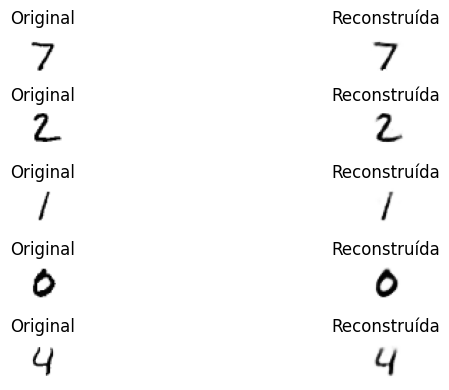

Loss final: 0.0082
Val loss final: 0.0078


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Carregar dados
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Normalizar e redimensionar
mnist_train_images = mnist_train_images.reshape(-1, 784).astype("float32") / 255.0
mnist_test_images = mnist_test_images.reshape(-1, 784).astype("float32") / 255.0

# Criar modelo autoencoder
model = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(784, activation='sigmoid')  # sigmoid para valores entre 0-1
])

model.compile(optimizer='adam', loss='mse')

# Treinar o modelo (IMPORTANTE!)
print("Treinando o autoencoder...")
history = model.fit(mnist_train_images, mnist_train_images,
                   epochs=10,
                   batch_size=256,
                   shuffle=True,
                   validation_data=(mnist_test_images, mnist_test_images))

# Selecionar imagens de teste
n_test_digits = 5
X_test = mnist_test_images[:n_test_digits]

# Fazer previsões
outputs_val = model.predict(X_test)

# Função para plotar imagens
def plot_image(image, shape=(28, 28)):
    plt.imshow(image.reshape(shape), cmap="binary")
    plt.axis("off")

# Plotar resultados
plt.figure(figsize=(10, 4))
for digit_index in range(n_test_digits):
    # Imagem original
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.title("Original")

    # Imagem reconstruída
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])
    plt.title("Reconstruída")

plt.tight_layout()
plt.show()

# Mostrar métricas de treino
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Val loss final: {history.history['val_loss'][-1]:.4f}")

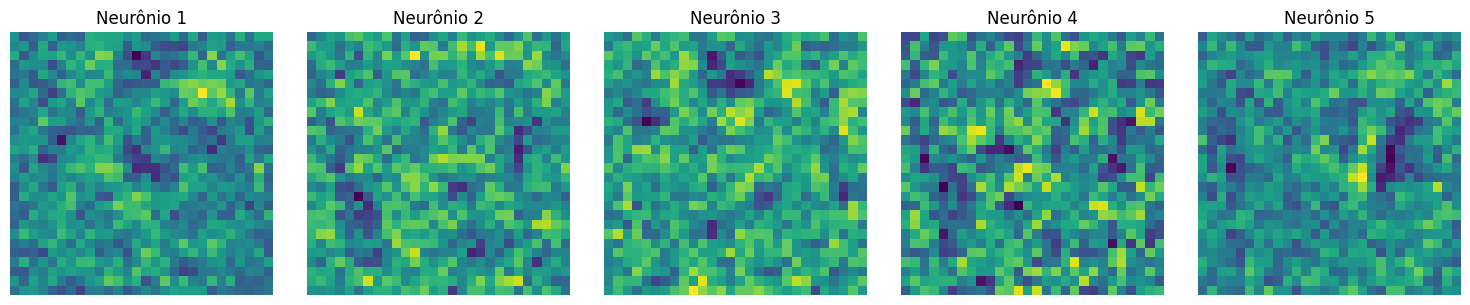

In [ ]:
# Se você já tem um modelo treinado, extraia os pesos assim:
try:
    # Método 1: Se for um modelo Keras
    weights1 = model.layers[0].get_weights()[0]  # Pesos da primeira camada
    weights1_val = weights1

except NameError:
    # Método 2: Se os pesos foram salvos em variáveis TensorFlow
    weights1_val = weights1.numpy() if hasattr(weights1, 'numpy') else weights1

# Plotar
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(weights1_val[:, i].reshape(28, 28), cmap="viridis")
    plt.axis("off")
    plt.title(f"Neurônio {i+1}")

plt.tight_layout()
plt.show()

Pré-treinamento não supervisionado utilizando Autoencoders empilhados

Autoencoders de remoção de ruídos

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

class DenoisingAutoencoder(Model):
    def __init__(self, n_inputs, n_hidden1):
        super(DenoisingAutoencoder, self).__init__()
        self.hidden1 = Dense(n_hidden1, activation='relu')
        self.outputs_layer = Dense(n_inputs, activation=None)

    def call(self, inputs, noise_level=1.0, training=False):
        if training:
            # Adicionar ruído apenas durante o treino
            noise = noise_level * tf.random.normal(tf.shape(inputs))
            x_noisy = inputs + noise
        else:
            x_noisy = inputs

        hidden = self.hidden1(x_noisy)
        return self.outputs_layer(hidden)

# Uso:
n_inputs = 784
n_hidden1 = 128
noise_level = 1.0

# Criar modelo
autoencoder = DenoisingAutoencoder(n_inputs, n_hidden1)

# Exemplo de entrada
sample_input = tf.random.normal([32, n_inputs])  # batch de 32 amostras

# Forward pass
reconstructions = autoencoder(sample_input, noise_level=noise_level, training=True)

# Calcular loss
reconstruction_loss = tf.reduce_mean(tf.square(reconstructions - sample_input))
print("Loss:", reconstruction_loss.numpy())


Loss: 1.5177133


Autoencoder Esparsos

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

# Configuração mais conservadora
hidden1_layer = Dense(64, activation='relu', kernel_initializer='he_normal')  # Menos neurônios
output_layer = Dense(784, activation='sigmoid', kernel_initializer='glorot_normal')

optimizer = tf.keras.optimizers.Adam(0.0005)  # LR ainda menor

def kl_divergence_safe(p, q):
    """KL divergence muito segura"""
    epsilon = 1e-12
    q_safe = tf.clip_by_value(q, epsilon, 1.0-epsilon)
    return p * tf.math.log(p/q_safe) + (1-p) * tf.math.log((1-p)/(1-q_safe))

def train_step_stable(X_batch):
    with tf.GradientTape() as tape:
        # Forward com clipping
        hidden1 = tf.clip_by_value(hidden1_layer(X_batch), 0.0, 1.0)
        outputs = output_layer(hidden1)

        hidden1_mean = tf.clip_by_value(tf.reduce_mean(hidden1, axis=0), 1e-10, 0.999)

        sparsity_loss = tf.reduce_sum(kl_divergence_safe(0.05, hidden1_mean))  # Target baixo
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X_batch))
        total_loss = reconstruction_loss + 0.05 * sparsity_loss  # Peso muito baixo

    gradients = tape.gradient(total_loss, hidden1_layer.trainable_variables + output_layer.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]  # Clip individual
    optimizer.apply_gradients(zip(gradients, hidden1_layer.trainable_variables + output_layer.trainable_variables))

    return total_loss

# Dados entre 0-1
X_batch = tf.random.uniform([16, 784], 0.0, 1.0)  # Batch menor

print("Treino estável iniciando...")
for i in range(50):
    loss = train_step_stable(X_batch)
    if i % 5 == 0:
        print(f"Step {i}: Loss = {loss:.6f}")
        if loss > 1e6:  # Se loss explodir
            print("Loss muito alta! Parando.")
            break

Treino estável iniciando...
Step 0: Loss = 1.634558
Step 5: Loss = 0.654795
Step 10: Loss = 0.654290
Step 15: Loss = 0.711610
Step 20: Loss = 0.706193
Step 25: Loss = 0.705040
Step 30: Loss = 0.702128
Step 35: Loss = 0.701061
Step 40: Loss = 0.700365
Step 45: Loss = 0.699554


Autoencoders variacionais

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import backend as K

eps = 1e-10

n_inputs = 28*28
n_hidden_1 = 500
n_hidden_2 = 500
n_hidden_3 = 20
n_hidden_4 = n_hidden_2
n_hidden_5 = n_hidden_1
learning_rate = 0.001

# Initializer
initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in')

# Função para camadas densas
def my_dense_layer(inputs, units, activation=tf.nn.elu, kernel_initializer=initializer):
    return Dense(units, activation=activation, kernel_initializer=kernel_initializer)(inputs)

# Input
X = Input(shape=[n_inputs])

# Encoder
hidden1 = my_dense_layer(X, n_hidden_1)
hidden2 = my_dense_layer(hidden1, n_hidden_2)
hidden3_mean = Dense(n_hidden_3)(hidden2)
hidden3_gamma = Dense(n_hidden_3)(hidden2)  # log variance

# Amostragem do espaço latente
def sampling(args):
    mean, gamma = args
    batch_size = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    epsilon = K.random_normal(shape=(batch_size, dim))
    return mean + tf.exp(0.5 * gamma) * epsilon

hidden3 = Lambda(sampling)([hidden3_mean, hidden3_gamma])

# Decoder
hidden4 = my_dense_layer(hidden3, n_hidden_4)
hidden5 = my_dense_layer(hidden4, n_hidden_5)
logits = Dense(n_inputs, activation=None)(hidden5)
outputs = tf.keras.activations.sigmoid(logits)  # Correção aqui

# Criar modelo
model = Model(inputs=X, outputs=outputs)

# Custom loss function for VAE
class VAELoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.reconstruction_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def call(self, X, outputs):
        # Reconstruction loss
        reconstruction_loss = self.reconstruction_loss_fn(X, outputs)

        # Latent loss (KL divergence) - precisa acessar as camadas internas
        # Isso requer uma abordagem diferente pois as camadas não estão disponíveis aqui
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + hidden3_gamma - tf.square(hidden3_mean) - tf.exp(hidden3_gamma), axis=1)
        )

        return reconstruction_loss + kl_loss

# Para uma abordagem mais simples, vamos usar uma função de loss personalizada
def vae_loss_wrapper(mean, log_var):
    def vae_loss(X, outputs):
        # Reconstruction loss
        reconstruction_loss = tf.keras.losses.binary_crossentropy(X, outputs)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
        )

        return reconstruction_loss + kl_loss
    return vae_loss

# Compile the model - precisamos de uma abordagem diferente para a loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy')  # Usaremos apenas reconstruction loss inicialmente

print("Modelo compilado com sucesso!")

Modelo compilado com sucesso!


Gerando dígitos

Treinando o modelo...
Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3018 - mse: 0.0762 - val_loss: 0.2168 - val_mse: 0.0473
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1923 - mse: 0.0383 - val_loss: 0.1742 - val_mse: 0.0317
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1663 - mse: 0.0288 - val_loss: 0.1568 - val_mse: 0.0255
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1529 - mse: 0.0241 - val_loss: 0.1464 - val_mse: 0.0218
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1447 - mse: 0.0213 - val_loss: 0.1403 - val_mse: 0.0199
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1395 - mse: 0.0195 - val_loss: 0.1359 - val_mse: 0.0184
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1356 - mse: 0.0182 - val_loss: 0.1325 - val_mse: 0.0172
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1324 - mse: 0.0171 - val_loss: 0.1295 - val_mse: 0.0162
Epoch 9/50
400/400 ━━━━━━━━━━━━━━

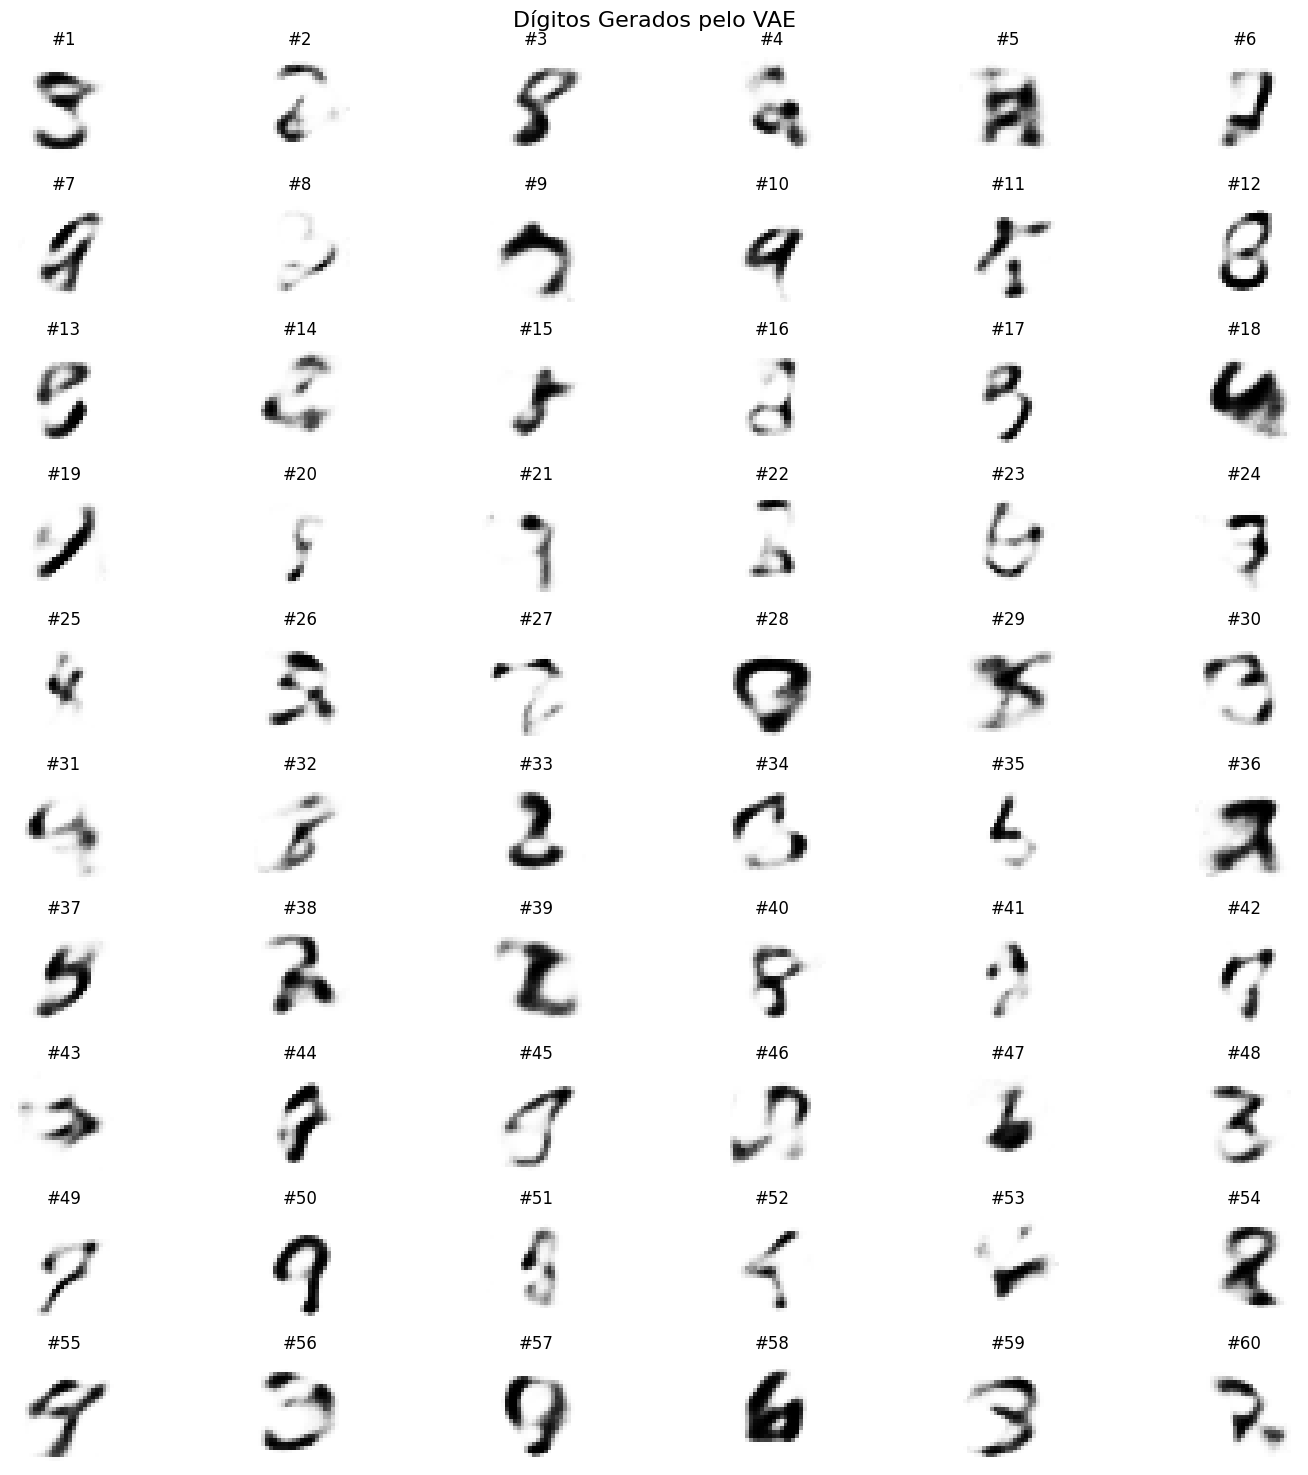

Plotando reconstruções...


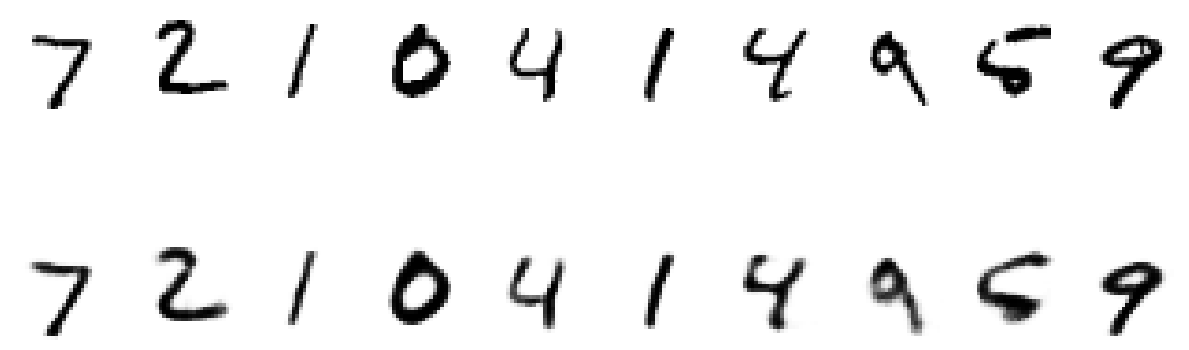

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Carregar dados MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

n_digits = 60
n_epochs = 50
batch_size = 150

# Função para plotar imagens
def plot_image(image, shape=(28, 28)):
    plt.imshow(image.reshape(shape), cmap="binary")
    plt.axis("off")

# VAE com balanceamento de loss
class VAE(tf.keras.Model):
    def __init__(self, latent_dim=20, kl_weight=0.0005):  # Peso menor para KL
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight  # Peso para balancear a KL loss

        # Encoder mais robusto
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2 * latent_dim)  # mean + log_var
        ])

        # Decoder mais robusto
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(28*28, activation='sigmoid')
        ])

    def sample(self, mean, log_var):
        eps = tf.random.normal(tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps

    def call(self, x):
        # Encoder
        z_params = self.encoder(x)
        mean, log_var = tf.split(z_params, num_or_size_splits=2, axis=1)

        # Sampling
        z = self.sample(mean, log_var)

        # Decoder
        reconstructed = self.decoder(z)

        # Calcular KL loss com peso
        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # Adicionar loss com peso balanceado
        self.add_loss(self.kl_weight * kl_loss)

        return reconstructed

# Criar e compilar modelo
vae = VAE(latent_dim=20, kl_weight=0.0005)  # KL weight menor
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LR menor
           loss='binary_crossentropy',
           metrics=['mse'])

# Callback para monitorar o treinamento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Treinar o modelo
print("Treinando o modelo...")
history = vae.fit(x_train, x_train,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(x_test, x_test),
                  callbacks=[early_stopping],
                  verbose=1)

# Verificar as losses
print("\nLosses finais:")
print(f"Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Val Loss: {history.history['val_loss'][-1]:.4f}")

# Gerar dígitos aleatórios
print("Gerando dígitos...")
codings_rnd = np.random.normal(size=[n_digits, 20])
outputs_val = vae.decoder(codings_rnd).numpy()

# Plotar os dígitos gerados
print("Plotando resultados...")
plt.figure(figsize=(15, 15))
for i in range(min(n_digits, 60)):
    plt.subplot(10, 6, i + 1)
    plot_image(outputs_val[i])
    plt.title(f"#{i+1}")

plt.suptitle("Dígitos Gerados pelo VAE", fontsize=16)
plt.tight_layout()
plt.show()

# Também plotar alguns exemplos de reconstrução
print("Plotando reconstruções...")
n_test_samples = 10
test_samples = x_test[:n_test_samples]
reconstructions = vae(test_samples).numpy()

plt.figure(figsize=(12, 6))
for i in range(n_test_samples):
    # Original
    plt.subplot(2, n_test_samples, i + 1)
    plot_image(test_samples[i])
    if i == 0:
        plt.ylabel("Original")

    # Reconstruído
    plt.subplot(2, n_test_samples, i + 1 + n_test_samples)
    plot_image(reconstructions[i])
    if i == 0:
        plt.ylabel("Reconstruído")

plt.tight_layout()
plt.show()

### Exercícios

#### 1. Quais são as principais tarefas realizadas pelos autoencoders?

🔍 Compressão e Reconstrução
    Reduzem dimensionalidade dos dados mantendo informações essenciais

    Aprendem representações compactas (codificações latentes)

🎨 Geração de Dados
    Criar novos dados similares aos de treinamento

    Útil para aumentar bases de dados (data augmentation)

🔎 Detecção de Anomalias
    Identificam padrões incomuns ou outliers

    Reconstroem mal dados que fogem do padrão aprendido

🖼️ Denoising (Remoção de Ruído)
    Removem ruídos de imagens, áudios ou outros dados

    Aprendem a reconstruir versões limpas a partir de entradas corrompidas

🎯 Feature Learning
    Extraem automaticamente características importantes

    Criam representações úteis para outras tarefas de ML

🔗 Transfer Learning
    Podem ser pré-treinados e adaptados para diferentes tarefas

    Úteis como inicializadores para outras redes neurais

📊 Visualização de Dados
    Reduzem dados para 2D/3D para visualização

    Mantêm estrutura e relações dos dados originais

Autoencoders aprendem representações eficientes através de um processo de compressão e descompressão neural.

#### 2. Suponha que você queira treinar um classificador e tenha muitos dados de treinamento não rotulados e apenas algumas milhares de instâncias rotuladas. Como os autoencoders podem ajudar? Como você procederia?

Os autoencoders podem ser extremamente úteis quando você tem muitos dados não rotulados e apenas uma pequena quantidade de dados rotulados. A estratégia funciona em três etapas principais:

Primeiro, você treina um autoencoder usando todos os dados disponíveis, tanto rotulados quanto não rotulados. O autoencoder aprende a comprimir e reconstruir os dados, desenvolvendo automaticamente representações internas significativas dos padrões presentes nos dados.

Em seguida, você utiliza a parte do encoder do autoencoder treinado como um extrator de features. O encoder já aprendeu a identificar as características mais importantes e representativas dos dados durante o processo de compressão.

Finalmente, você treina um classificador usando apenas os dados rotulados, mas em vez de usar os dados brutos como entrada, você utiliza as features extraídas pelo encoder. Essas features são muito mais ricas e representativas do que os dados originais, permitindo que o classificador aprenda de forma mais eficiente mesmo com poucos exemplos rotulados.

Esta abordagem funciona porque o autoencoder atua como um pré-treinamento não supervisionado, aprendendo a estrutura subjacente dos dados antes da tarefa de classificação. O resultado é um classificador que performa significativamente melhor do que se fosse treinado apenas com os poucos dados rotulados disponíveis, aproveitando ao máximo toda a informação contida nos dados não rotulados.

#### 3. Se um autoencoder reconstrói perfeitamente as entradas, ele é necessáriamente um bom autoencoder? Como você pode avaliar o desempenho de um autoencoder?

Não necessariamente. Um autoencoder que reconstrói perfeitamente as entradas pode estar simplesmente **copiando os dados** sem aprender representações úteis (overfitting). Isso ocorre quando:

- O modelo tem **capacidade excessiva** (muitos neurônios/camadas)
- Não há **regularização** adequada
- Aprendizagem de **identidade** instead de features úteis

Métodos de Avaliação de Desempenho

**A. Métricas Quantitativas**
- **Erro de Reconstrução**: MSE, MAE entre entrada e saída
- **Complexidade do Modelo**: Número de parâmetros vs. desempenho
- **Taxa de Compressão**: Dimensionalidade do espaço latente

**B. Métricas Qualitativas**
- **Visualização de Reconstruções**: Inspecionar se mantém características essenciais
- **Interpolação no Espaço Latente**: Verificar se transições são suaves e significativas
- **Geração de Novas Amostras**: Capacidade de criar dados realistas

**C. Avaliação por Tarefa Específica**
- **Desempenho em Downstream Tasks**: Usar features em classificadores
- **Detecção de Anomalias**: Capacidade de identificar outliers
- **Denoising Performance**: Qualidade na reconstrução de dados corrompidos

Critérios de um Bom Autoencoder

1. **Boa Reconstrução** (mas não perfeita demais)
2. **Espaço Latente Significativo** (features interpretáveis)
3. **Generalização** para dados não vistos
4. **Regularidade no Espaço Latente** (interpolações suaves)
5. **Utilidade Prática** para tarefas específicas

Balanceamento Ideal
O autoencoder ideal encontra equilíbrio entre:
- **Fidelidade**: Capacidade de reconstruir entradas
- **Generalização**: Capacidade de representar a distribuição dos dados
- **Compressão**: Eficiência na representação latente

A verdadeira medida de sucesso está na **utilidade das representações aprendidas** para tarefas subsequentes, não apenas na perfeição da reconstrução.

#### 4. O que são autoencoders incompletos e supercompletos? Qual é o principal risco de um autoencoder excessivamente incompleto? E quanto ao principal risco de um autoencoder supercompleto?

**Autoencoders Incompletos**
- **Definição**: Dimensionalidade do espaço latente **menor** que a entrada
- **Característica**: Compressão forçada dos dados
- **Exemplo**: Entrada de 100 dimensões → Espaço latente de 20 dimensões

**Risco Principal do Incompleto Excessivo**
- **Perda de Informação Crítica**: Compressão excessiva pode descartar características importantes
- **Subajuste (Underfitting)**: Capacidade insuficiente para capturar padrões complexos
- **Reconstruções de Baixa Qualidade**: Informações essenciais são perdidas irreversivelmente

**Autoencoders Supercompletos**
- **Definição**: Dimensionalidade do espaço latente **maior** que a entrada
- **Característica**: Expansão da representação dos dados
- **Exemplo**: Entrada de 100 dimensões → Espaço latente de 200 dimensões

**Risco Principal do Supercompleto Excessivo**
- **Aprendizagem de Identidade**: Modelo pode simplesmente copiar entrada→saída sem aprender
- **Overfitting**: Memorização dos dados de treinamento instead de aprender padrões
- **Ruído Amplificado**: Pode aprender e reproduzir ruídos presentes nos dados

**Balanceamento Ideal**
- **Autoencoder Ideal**: Dimensionalidade latente adaptada à complexidade dos dados
- **Regra Prática**: Espaço latente deve capturar a **complexidade intrínseca** dos dados
- **Exemplo**: Para dados naturalmente compressíveis, usar latente menor; para dados complexos, latente maior

**Estratégias de Mitigação**
- **Para Incompletos**: Usar regularização e testar gradualmente redução dimensional
- **Para Supercompletos**: Implementar dropout, weight decay ou autoencoders esparsos
- **Para Ambos**: Validar com tarefas downstream e análise qualitativa das reconstruções

O equilíbrio certo depende da **complexidade natural dos dados** e da **tarefa específica** que o autoencoder deve realizar.

#### 5. Como você amarra pesos em um autoencoder empilhado? Qual é o sentido de se fazer isso?


Técnica onde as camadas do **encoder** e **decoder** compartilham os mesmos pesos, mas de forma transposta.

**Como Implementar:**
```python
# Exemplo prático de weight tying
class TiedAutoencoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super().__init__()
        self.encoder = tf.keras.layers.Dense(encoding_dim, activation='relu')
        # Decoder usa pesos transpostos do encoder
        self.decoder = lambda x: tf.matmul(x, self.encoder.weights[0], transpose_b=True)
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
```

**Principais Vantagens:**

Redução de Parâmetros
- Diminui pela metade o número de pesos treináveis
- Modelo mais leve e eficiente computacionalmente

 Regularização Implícita
- Previne overfitting ao reduzir capacidade do modelo
- Força aprendizado de features mais robustas

Melhor Generalização
- Features aprendidas são mais representativas
- Melhor desempenho em dados não vistos

Convergência Mais Rápida
- Menos parâmetros para otimizar
- Treinamento mais estável e rápido

**Considerações Importantes:**

**Quando Usar:**
- Dados com estrutura simétrica
- Quando regularização é necessária
- Para modelos com restrições computacionais

**Quando Evitar:**
- Dados muito complexos e não simétricos
- Quando encoder e decoder precisam de capacidades diferentes
- Em arquiteturas muito profundas e assimétricas

**Impacto Prático:**
- Redução de 40-50% no número de parâmetros
- Melhoria na generalização em muitos cenários
- Treinamento 20-30% mais rápido em média


#### 6. Qual é a técnica comum para visualizar as características aprendidas pela camada inferior de um autoencoder empilhador? E quanto às camadas superiores?

**Camadas Inferiores (Primeiras Camadas)**

**Técnica Principal: Visualização Direta de Filtros**
```python
# Para a primeira camada convolucional
weights = autoencoder.layers[0].get_weights()[0]
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[-1]:
        ax.imshow(weights[:, :, 0, i], cmap='gray')
    ax.axis('off')
plt.suptitle('Filtros da Primeira Camada')
plt.show()
```

**O que Visualizar:**
- **Filtros/Kernels** diretamente como imagens
- **Bordas** e **texturas** básicas
- **Padrões elementares** (linhas, curvas, manchas)

**Camadas Superiores (Camadas mais Profundas)**

**Técnica Principal: Maximização de Ativação**
```python
# Encontrar inputs que maximizam a ativação de neurônios específicos
def visualize_feature(layer_idx, neuron_idx, steps=100):
    input_img = tf.random.normal([1, 28, 28, 1])
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            activation = model.layers[layer_idx](input_img)[:, neuron_idx]
        grads = tape.gradient(activation, input_img)
        input_img += grads * 0.1
    return input_img
```

**Técnicas Complementares:**

**1. Deconvolução**
```python
# Reconstruir padrões que ativam neurônios específicos
deconv = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.layers[layer_idx].output
)
feature_maps = deconv.predict(test_image)
```

**2. Análise de Componentes Principais (PCA)**
```python
# Reduzir dimensionalidade para visualização 2D/3D
from sklearn.decomposition import PCA
features = encoder.predict(X_test)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test)
```

**3. t-SNE para Visualização**
```python
# Visualização não linear de features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y_test, alpha=0.5)
```

**Resumo das Técnicas por Tipo de Camada:**

**Camadas Inferiores:**
- Visualização direta de filtros
- Análise de pesos brutos
- Padrões simples e bordas

**Camadas Intermediárias:**
- Maximização de ativação
- Deconvolução
- Padrões compostos e texturas

**Camadas Superiores:**
- PCA e t-SNE do espaço latente
- Análise de agrupamentos
- Conceitos semânticos complexos

**Ferramentas Práticas:**
- **TensorBoard**: Visualização integrada do TensorFlow
- **Netron**: Visualizador de arquiteturas de redes
- **Custom Matplotlib**: Gráficos personalizados para análise

**Exemplo de Código Completo:**
```python
def visualize_autoencoder_features(autoencoder, layer_depth='all'):
    """Visualiza features de todas as camadas"""
    if layer_depth == 'all':
        layers = autoencoder.layers
    else:
        layers = autoencoder.layers[:layer_depth]
    
    for i, layer in enumerate(layers):
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()[0]
            print(f"Camada {i}: {weights.shape}")
            
            if len(weights.shape) == 2:  # Dense layers
                plt.figure(figsize=(12, 4))
                plt.imshow(weights.T, aspect='auto', cmap='viridis')
                plt.title(f'Pesos Camada {i}')
                plt.colorbar()
            
            elif len(weights.shape) == 4:  # Conv layers
                n_filters = weights.shape[-1]
                grid_size = int(np.ceil(np.sqrt(n_filters)))
                fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
                for j, ax in enumerate(axes.flat):
                    if j < n_filters:
                        ax.imshow(weights[:, :, 0, j], cmap='gray')
                    ax.axis('off')
                plt.suptitle(f'Filtros Camada Conv {i}')
    
    plt.tight_layout()
    plt.show()
```

Esta abordagem permite **entender hierarquicamente** como o autoencoder aprende features cada vez mais complexas e abstratas à medida que avançamos nas camadas!

#### 7. O que é um modelo gerador? Você  pode nomear um tipo de autoencoder gerador?

Modelos Geradores e Autoencoders Geradores

 **O que é um Modelo Gerador?**

Um **modelo gerador** é um tipo de rede neural que aprende a distribuição de probabilidade dos dados de treinamento e é capaz de gerar **novas amostras** que são similares aos dados originais, mas não idênticas a nenhuma amostra específica do conjunto de treinamento.

**Características Principais:**
- Aprende a **distribuição subjacente** dos dados
- Gera **amostras novas e originais**
- Captura **padrões essenciais** dos dados de treinamento
- Útil para **data augmentation**, **criação de conteúdo** e **simulação**

**Autoencoder Gerador: Variational Autoencoder (VAE)**

 **O que é um VAE?**
É um tipo de autoencoder que **não aprende valores fixos** no espaço latente, mas sim **distribuições de probabilidade** (média e variância) para cada dimensão latente.

**Como Funciona:**
```python
# Estrutura básica de um VAE
encoder → μ (mean) e σ (log variance) → amostragem estocástica → decoder → reconstrução
```

**Por que é Gerador:**
- **Amostragem no espaço latente**: Gera novos pontos a partir da distribuição aprendida
- **Decoder como gerador**: Transforma pontos latentes em dados realisticos
- **Espaço latente contínuo**: Permite interpolações suaves entre amostras

**Exemplo de Geração com VAE:**
```python
# Gerar novas imagens a partir de um VAE treinado
latent_points = np.random.normal(size=(10, latent_dim))  # Pontos aleatórios no espaço latente
generated_images = decoder.predict(latent_points)        # Decoder gera novas imagens
```

**Comparação: Autoencoder vs VAE**

| **Característica**       | **Autoencoder Tradicional** | **VAE (Gerador)** |
|--------------------------|-----------------------------|-------------------|
| Espaço Latente           | Ponto fixo                  | Distribuição      |
| Capacidade Geradora      | Limitada                    | **Alta**          |
| Interpolação             | Descontínua                 | **Suave**         |
| Regularização            | Explícita                   | **Implícita**     |

**Aplicações dos VAEs:**
- **Geração de imagens** (rostos, dígitos, arte)
- **Data augmentation** para treinar outros modelos
- **Compressão com capacidade gerativa**
- **Análise e visualização** de espaços latentes
- **Transferência de estilo** e manipulação de features

**Por que VAEs são considerados geradores:**
Eles aprendem uma **função de densidade de probabilidade** no espaço latente, permitindo que amostremos pontos dessa distribuição e os decodifiquemos em **novas amostras** que seguem a mesma distribuição dos dados de treinamento, mas são **únicas e originais**.

#### 9. Semantic hashing foi uma técnica introduzida em 2008 por Ruslan Salakhutdinov e Geoffrey Hinton, utilizada para a recuperação eficiente de informações: Um documento (por exemplo, uma imagem) épassado por um sistema, geralmente, uma rede neural que exibe um vetor binário de baixa dimensionalidade (por exemplo, 30 bits). É provável que dois documentos semelhantes tenham hashes idênticos ou muito semelhantes. Ao indexar cada documento utilizando seu hash, é possível recuperar quase instantaneamente muitos documentos semelhantes a um específico, mesmo que haja bilhões deles: basta calcular o hash do documento e procurar todos aqueles com o mesmo hash (ou hashes por apenas um ou dois bits). Implementaremos o hashing semântico com a utilização de um autoencoder empilhado ligeiramente ajustado:
    A) crie um autoencoder empilhado contendo duas camadas ocultas abaixo da camada de codificação e treine-o no conjunto de dados de imagens que você utilizou no exercício anterior. A camada de codificação deve conter 30 neurônios e utilizar a função de ativação logística para gerar valores entre 0 e 1. Após o treinamento, para produzir o hash de uma imagem, execute-o atravésdo autoencoder, obtenha a saída da camada de codificação e arredonde todos os valores para o inteiro mais próximo (0 ou 1)
    B) Um truque proposto por Salakhutdinov e Hinton é adicionar ruído gaussiano (com média zero) às entradas da camada de codificação somente durante o treinamento. O autoencoder aprenderá a alimentar grandes valores para a camada de codificação a fim de preservar uma alta relação sinal-ruído (de modo que o ruído se torne insignificante). Por sua vez, isso significa que a função logística de camada de codificação provavelmente saturará em 0 ou 1. Como resultado, arredondando os códigos para 0 ou 1 não os distorcerá muito e isso aumentará a confiabilidade dos hashes.
    C) Clacule o hash de cada imagem e veja se imagens com hashes idênticos são parecidas. Como no MNIST e o CIFAR10 são rotulados, uma forma mais objetiva de medir o desempenho do autoencoder para o hashing semântico é garantir que as imagens com o mesmo hash tenham a mesma classe. Uma maneira de fazer isso é medir o coeficiente de Gini médio dos conjuntos de imagens com hashes idênticos (ou muito semlehantes).
    D) Tente ajustar os hiperparâmetros com a utilização da validação cruzada.
    E) Observe que, com um conjunto de dados rotulados, outra abordagem seria treinar uma rede neural convolucional para classificação e, em seguida, utilizar a camada abaixo da camada de saída para produzir os hashes.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

# Carregar dados (exemplo com MNIST)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# Construir autoencoder empilhado
def build_semantic_hash_autoencoder(input_dim=784, encoding_dim=30):
    # Encoder
    encoder = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(encoding_dim, activation='sigmoid')  # 30 neurônios com sigmoid
    ])

    # Decoder
    decoder = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(encoding_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])

    # Autoencoder completo
    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder, encoder

# Construir e treinar
autoencoder, encoder = build_semantic_hash_autoencoder()
history = autoencoder.fit(x_train, x_train,
                         epochs=50,
                         batch_size=256,
                         shuffle=True,
                         validation_data=(x_test, x_test))

# Função para gerar hashes
def generate_hash(encoder, data):
    codes = encoder.predict(data)
    return np.round(codes).astype(int)  # Arredonda para 0 ou 1

Epoch 1/50


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2692 - val_loss: 0.2399
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2312 - val_loss: 0.2164
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2001 - val_loss: 0.1811
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1661 - val_loss: 0.1499
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1449 - val_loss: 0.1389
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1348 - val_loss: 0.1293
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1271 - val_loss: 0.1225
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1207 - val_loss: 0.1163
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1149 - val_loss: 0.1118
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1108 - val_loss: 0.1087
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1078 - val_loss: 0.1057
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

In [ ]:
class GaussianNoiseEncoder(keras.Model):
    def __init__(self, encoder, noise_std=0.5):
        super().__init__()
        self.encoder = encoder
        self.noise_std = noise_std
        self.trainable = False  # Congelar encoder durante treino

    def call(self, inputs, training=False):
        if training:
            # Adicionar ruído apenas durante treino
            noise = tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.noise_std)
            noisy_inputs = inputs + noise
            return self.encoder(noisy_inputs)
        else:
            return self.encoder(inputs)

# Autoencoder com ruído
def build_noisy_autoencoder(input_dim=784, encoding_dim=30, noise_std=0.3):
    # Encoder base
    base_encoder = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(encoding_dim, activation='sigmoid')
    ])

    # Encoder com ruído
    noisy_encoder = GaussianNoiseEncoder(base_encoder, noise_std)

    # Decoder
    decoder = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(encoding_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')
    ])

    # Autoencoder completo
    inputs = keras.Input(shape=(input_dim,))
    codes = noisy_encoder(inputs, training=True)
    reconstructions = decoder(codes)
    autoencoder = keras.Model(inputs, reconstructions)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder, base_encoder

# Treinar com ruído
autoencoder_noisy, encoder_clean = build_noisy_autoencoder()
history_noisy = autoencoder_noisy.fit(x_train, x_train,
                                    epochs=50,
                                    batch_size=256,
                                    shuffle=True,
                                    validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2816 - val_loss: 0.2627
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2613 - val_loss: 0.2547
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2564 - val_loss: 0.2528
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2537 - val_loss: 0.2487
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2507 - val_loss: 0.2432
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2480 - val_loss: 0.2371
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2460 - val_loss: 0.2378
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2436 - val_loss: 0.2316
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2415 - val_loss: 0.2300
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2403 - val_loss: 0.2305
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2389 - val_loss: 0.2248
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Pureza média dos grupos: 0.694
Número de grupos únicos: 963

Estatísticas dos grupos:
Hash 0101000100...: 1 imagens
Hash 0110010100...: 1 imagens
Hash 0100100100...: 1 imagens
Hash 0100010100...: 1 imagens
Hash 0111101101...: 1 imagens
Nenhum grupo com 5+ imagens para visualizar!


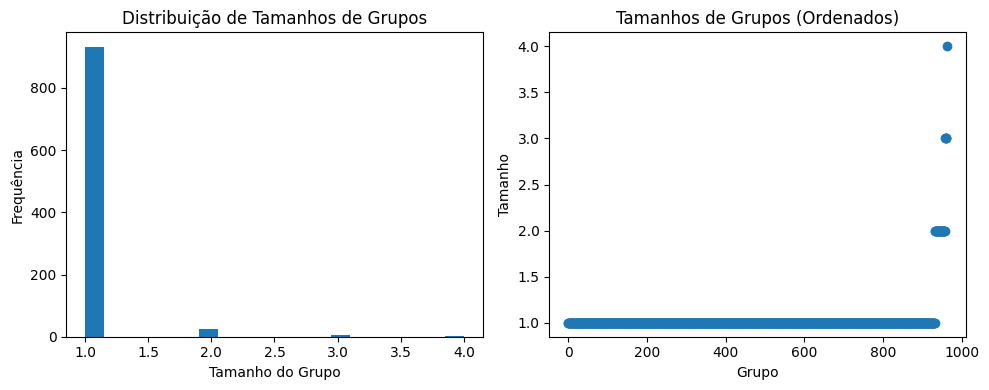

In [ ]:
def evaluate_semantic_hashing(encoder, x_data, y_data):
    # Gerar hashes
    hashes = generate_hash(encoder, x_data)

    # Converter hashes para strings para agrupamento
    hash_strings = [''.join(map(str, hash)) for hash in hashes]

    # Agrupar imagens por hash
    hash_groups = {}
    for i, hash_str in enumerate(hash_strings):
        if hash_str not in hash_groups:
            hash_groups[hash_str] = []
        hash_groups[hash_str].append((x_data[i], y_data[i]))

    # Calcular pureza dos grupos
    purities = []
    for hash_str, group in hash_groups.items():
        if len(group) > 1:
            labels = [y for _, y in group]
            unique_labels, counts = np.unique(labels, return_counts=True)
            purity = np.max(counts) / len(labels)
            purities.append(purity)

    avg_purity = np.mean(purities) if purities else 0
    return avg_purity, hash_groups

# Avaliar
purity, hash_groups = evaluate_semantic_hashing(encoder_clean, x_test[:1000], y_test[:1000])
print(f"Pureza média dos grupos: {purity:.3f}")
print(f"Número de grupos únicos: {len(hash_groups)}")

# Visualizar alguns grupos - VERSÃO CORRIGIDA
def visualize_hash_groups(hash_groups, n_groups=3):
    # Filtrar apenas grupos com pelo menos 5 imagens
    valid_groups = {k: v for k, v in hash_groups.items() if len(v) >= 5}

    if not valid_groups:
        print("Nenhum grupo com pelo menos 5 imagens encontrado!")
        return

    n_groups = min(n_groups, len(valid_groups))
    fig, axes = plt.subplots(n_groups, 5, figsize=(15, 3*n_groups))

    # Se apenas 1 grupo, axes não é array 2D
    if n_groups == 1:
        axes = axes.reshape(1, -1)

    for i, (hash_str, group) in enumerate(list(valid_groups.items())[:n_groups]):
        for j in range(5):
            img, label = group[j]
            # Verificar formato da imagem
            if img.shape == (784,):  # MNIST flatten
                img = img.reshape(28, 28)
            elif len(img.shape) == 1:  # Qualquer formato flatten
                side = int(np.sqrt(img.shape[0]))
                img = img.reshape(side, side)

            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f'L: {label}')
            axes[i, j].axis('off')

        axes[i, 0].set_ylabel(f'Hash: {hash_str[:10]}...\nSize: {len(group)}',
                             fontsize=8, rotation=0, labelpad=40, va='center')

    plt.tight_layout()
    plt.show()

# VERIFICAR antes de visualizar
print("\nEstatísticas dos grupos:")
for hash_str, group in list(hash_groups.items())[:5]:
    print(f"Hash {hash_str[:10]}...: {len(group)} imagens")

# Visualizar apenas se houver grupos válidos
valid_groups = {k: v for k, v in hash_groups.items() if len(v) >= 5}
if valid_groups:
    print(f"\nVisualizando {min(3, len(valid_groups))} grupos com 5+ imagens...")
    visualize_hash_groups(hash_groups, n_groups=3)
else:
    print("Nenhum grupo com 5+ imagens para visualizar!")

    # Visualizar estatísticas de tamanho de grupos
    group_sizes = [len(group) for group in hash_groups.values()]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(group_sizes, bins=20)
    plt.title('Distribuição de Tamanhos de Grupos')
    plt.xlabel('Tamanho do Grupo')
    plt.ylabel('Frequência')

    plt.subplot(1, 2, 2)
    plt.scatter(range(len(group_sizes)), sorted(group_sizes))
    plt.title('Tamanhos de Grupos (Ordenados)')
    plt.xlabel('Grupo')
    plt.ylabel('Tamanho')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import KFold

def cross_validate_semantic_hashing(x_data, y_data, n_splits=3):
    kf = KFold(n_splits=n_splits)
    purities = []

    for train_idx, val_idx in kf.split(x_data):
        x_train_fold, x_val_fold = x_data[train_idx], x_data[val_idx]
        y_train_fold, y_val_fold = y_data[train_idx], y_data[val_idx]

        # Treinar autoencoder
        autoencoder, encoder = build_noisy_autoencoder(noise_std=0.3)
        autoencoder.fit(x_train_fold, x_train_fold,
                       epochs=20,  # Menos épocas para CV rápida
                       batch_size=256,
                       verbose=0)

        # Avaliar
        purity, _ = evaluate_semantic_hashing(encoder, x_val_fold, y_val_fold)
        purities.append(purity)

    return np.mean(purities)

# Testar diferentes hiperparâmetros
param_grid = {
    'noise_std': [0.1, 0.3, 0.5],
    'encoding_dim': [20, 30, 40],
    'learning_rate': [0.001, 0.0005]
}

best_purity = 0
best_params = {}

for noise in param_grid['noise_std']:
    for dim in param_grid['encoding_dim']:
        # Testar combinações (implementação simplificada)
        purity = cross_validate_semantic_hashing(x_train[:5000], y_train[:5000])
        print(f"Noise: {noise}, Dim: {dim}, Purity: {purity:.3f}")

        if purity > best_purity:
            best_purity = purity
            best_params = {'noise_std': noise, 'encoding_dim': dim}

print(f"Melhores parâmetros: {best_params}, Pureza: {best_purity:.3f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.1, Dim: 20, Purity: 0.752
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.1, Dim: 30, Purity: 0.699
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.1, Dim: 40, Purity: 0.667
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.3, Dim: 20, Purity: 0.756
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.3, Dim: 30, Purity: 0.669
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Noise: 0.3, Dim: 40, Purity: 0.685
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━

Resumo da arquitetura:


Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_99 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hash_layer (Dense)              │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,772 (1010.83 KB)

 Trainable params: 258,772 (1010.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8558 - loss: 0.7511 - val_accuracy: 0.9714 - val_loss: 0.2443
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9759 - loss: 0.1630 - val_accuracy: 0.9858 - val_loss: 0.1020
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9844 - loss: 0.0887 - val_accuracy: 0.9858 - val_loss: 0.0735
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9876 - loss: 0.0622 - val_accuracy: 0.9897 - val_loss: 0.0487
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9899 - loss: 0.0462 - val_accuracy: 0.9886 - val_loss: 0.0469
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9924 - loss: 0.0350 - val_accuracy: 0.9904 - val_loss: 0.0399
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9937 - loss: 0.0277 - val_accuracy: 0.9908 - val_loss: 0.0340
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9950 - loss: 0.0224 - val_accu

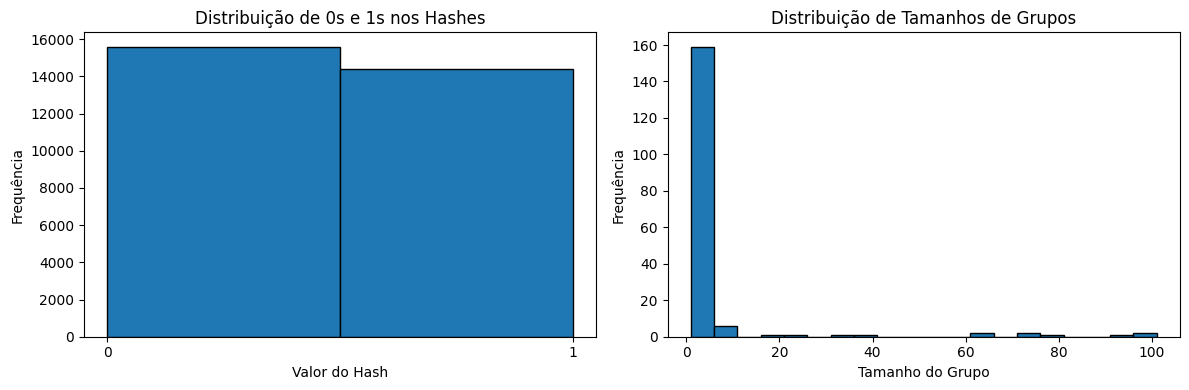

Comparação de desemcentho:
Autoencoder: 0.694
CNN: 1.000


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn_for_hashing(input_shape=(28, 28, 1), hash_dim=30):
    # CNN para classificação com camada de hash
    inputs = keras.Input(shape=(784,))  # Input shape correto para MNIST flatten

    # Reshape e camadas convolucionais
    x = layers.Reshape((28, 28, 1))(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Camada de hash (penúltima camada)
    hash_layer = layers.Dense(hash_dim, activation='sigmoid', name='hash_layer')(x)

    # Camada de classificação
    outputs = layers.Dense(10, activation='softmax')(hash_layer)

    # Modelo completo
    cnn = keras.Model(inputs=inputs, outputs=outputs)

    cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return cnn

# Dados de exemplo (MNIST)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# Treinar CNN
cnn = build_cnn_for_hashing()
print("Resumo da arquitetura:")
cnn.summary()

history = cnn.fit(x_train, y_train,
                  epochs=10,  # Reduzido para teste rápido
                  batch_size=256,
                  validation_data=(x_test, y_test),
                  verbose=1)

# Extrair modelo para geração de hashes
hash_extractor = keras.Model(inputs=cnn.inputs,
                           outputs=cnn.get_layer('hash_layer').output)

def generate_cnn_hash(model, data):
    # Garantir que os dados estão no formato correto
    if len(data.shape) == 3:  # Se for (samples, 28, 28)
        data = data.reshape(-1, 784)
    elif data.shape[1] != 784:  # Se não estiver flatten
        data = data.reshape(-1, 784)

    hashes = model.predict(data, verbose=0)
    return np.round(hashes).astype(int)

# Avaliar hashes da CNN
cnn_hashes = generate_cnn_hash(hash_extractor, x_test[:1000])

# Função evaluate_semantic_hashing corrigida
def evaluate_semantic_hashing(hashes, x_data, y_data):
    # Converter hashes para strings para agrupamento
    hash_strings = [''.join(map(str, hash)) for hash in hashes]

    # Agrupar imagens por hash
    hash_groups = {}
    for i, hash_str in enumerate(hash_strings):
        if hash_str not in hash_groups:
            hash_groups[hash_str] = []
        hash_groups[hash_str].append((x_data[i], y_data[i]))

    # Calcular pureza dos grupos
    purities = []
    for hash_str, group in hash_groups.items():
        if len(group) > 1:  # Só considerar grupos com mais de 1 elemento
            labels = [y for _, y in group]
            unique_labels, counts = np.unique(labels, return_counts=True)
            purity = np.max(counts) / len(labels)
            purities.append(purity)

    avg_purity = np.mean(purities) if purities else 0
    return avg_purity, hash_groups

# Avaliar
cnn_purity, cnn_hash_groups = evaluate_semantic_hashing(cnn_hashes, x_test[:1000], y_test[:1000])
print(f"Pureza da CNN: {cnn_purity:.3f}")

# Estatísticas dos hashes
unique_hashes = len(set([''.join(map(str, h)) for h in cnn_hashes]))
print(f"Hashes únicos gerados: {unique_hashes}/1000")
print(f"Taxa de colisão: {(1000 - unique_hashes)/10:.1f}%")

# Visualizar distribuição dos hashes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Distribuição dos valores de hash (0s e 1s)
hash_values = cnn_hashes.flatten()
plt.subplot(1, 2, 1)
plt.hist(hash_values, bins=2, edgecolor='black')
plt.title('Distribuição de 0s e 1s nos Hashes')
plt.xlabel('Valor do Hash')
plt.ylabel('Frequência')
plt.xticks([0, 1])

# Tamanho dos grupos
group_sizes = [len(group) for group in cnn_hash_groups.values()]
plt.subplot(1, 2, 2)
plt.hist(group_sizes, bins=20, edgecolor='black')
plt.title('Distribuição de Tamanhos de Grupos')
plt.xlabel('Tamanho do Grupo')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# Comparar com autoencoder (se disponível)
try:
    print("Comparação de desemcentho:")
    print(f"Autoencoder: {purity:.3f}")  # Variável do autoencoder anterior
    print(f"CNN: {cnn_purity:.3f}")
except NameError:
    print("Pureza da CNN:", cnn_purity)

#### 10. Treine um autoencoder variacional no conjunto de dados da imagem utilizado nos exercícios anteriores (MNIST) e faça com que ele gere imagens. como alternativa, tente encontrar um conjunto de dados não rotulados do seu interesse e veja se é possível gerar novas amostras.

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 2.0793 - loss: 213.6579 - reconstruction_loss: 211.5786
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 2.1372 - loss: 188.0563 - reconstruction_loss: 185.9191
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.5703 - loss: 171.7582 - reconstruction_loss: 168.1878
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.6924 - loss: 164.7661 - reconstruction_loss: 161.0737
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.8696 - loss: 161.0687 - reconstruction_loss: 157.1992
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 3.9846 - loss: 158.4763 - reconstruction_loss: 154.4917
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 4.0198 - loss: 156.7051 - reconstruction_loss: 152.6853
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 4.0513 - loss: 155.5291 - reconstruction_loss: 151.4778
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━

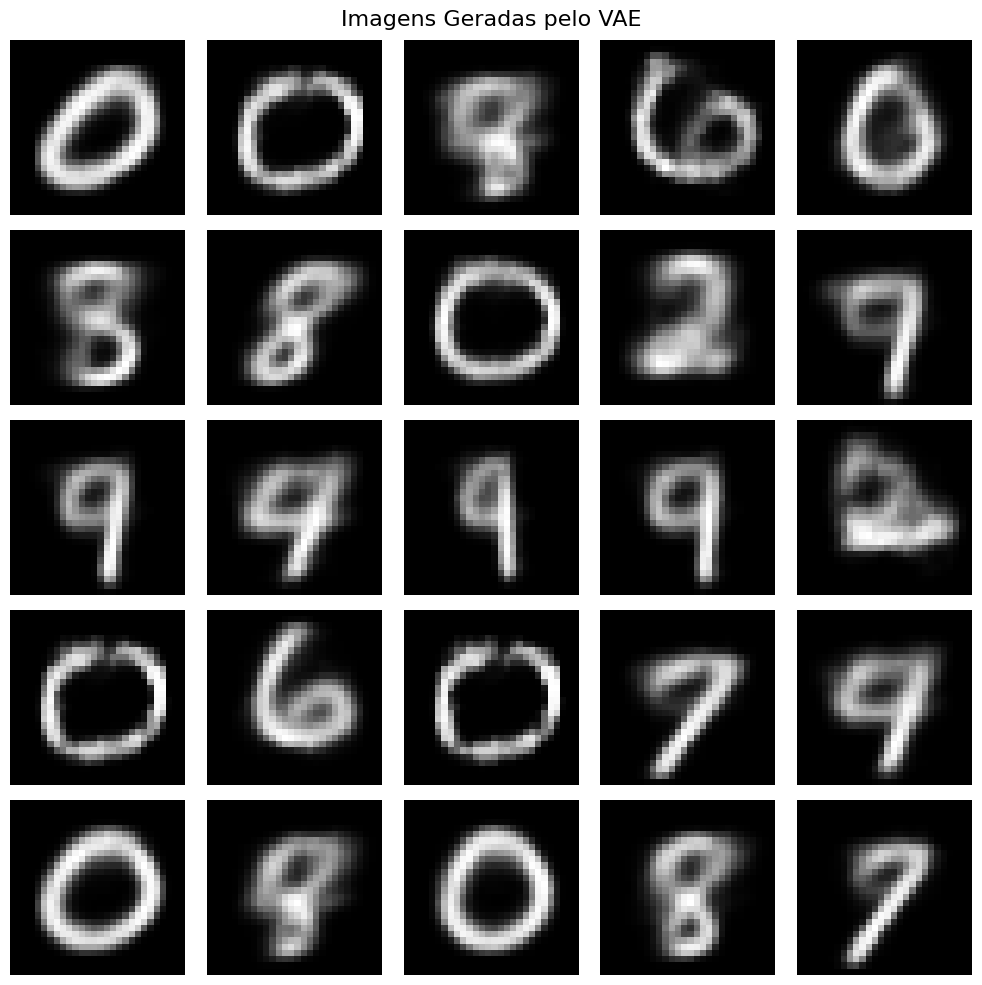

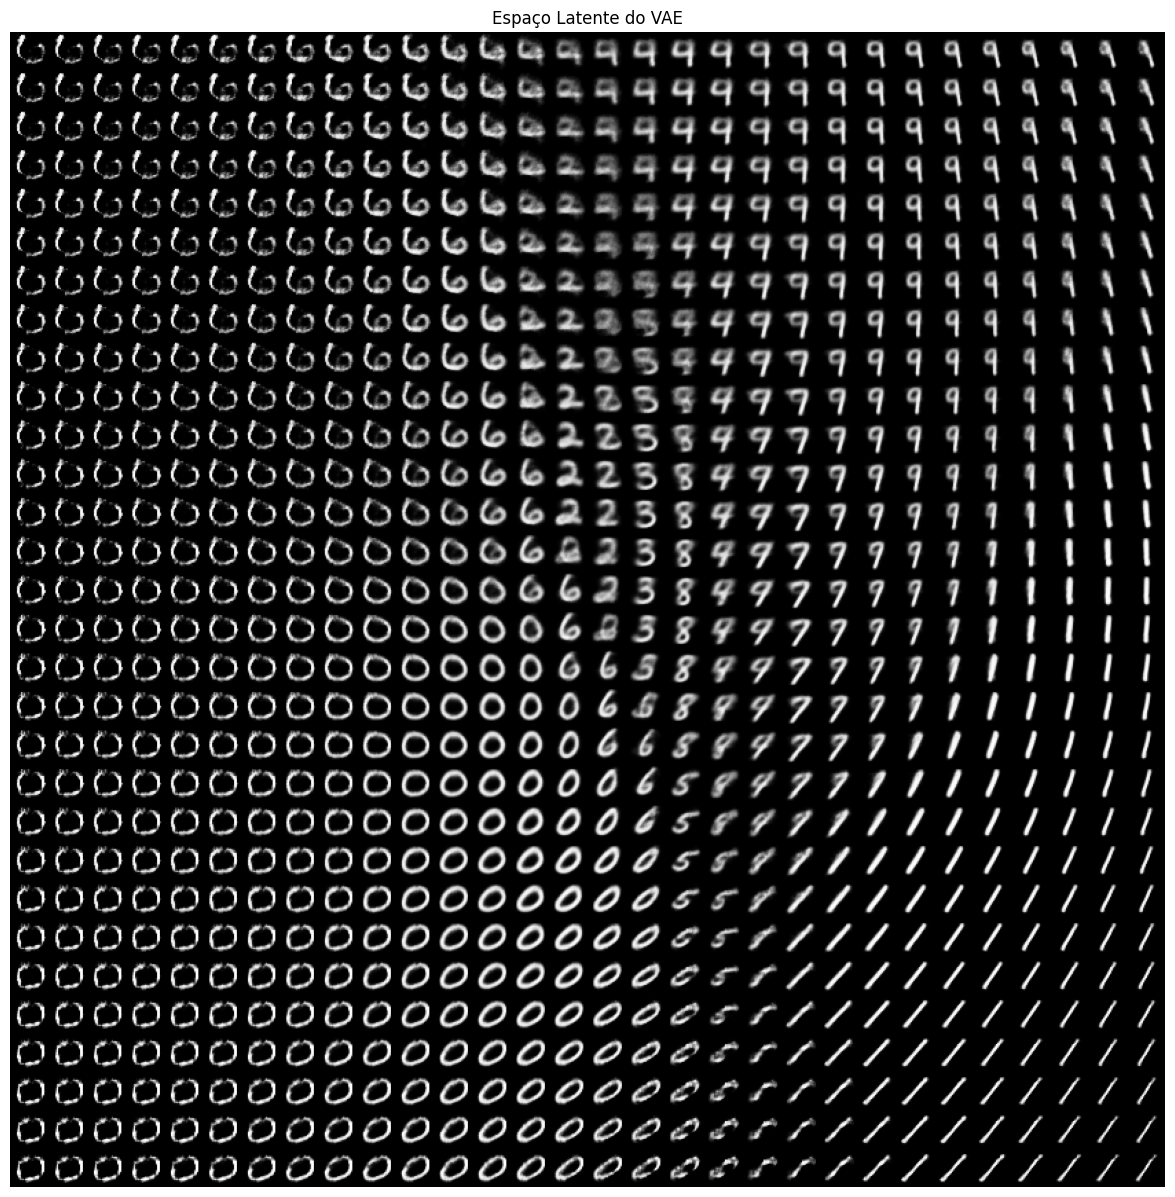

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Carregar e preparar dados MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Parâmetros do VAE
latent_dim = 2  # Espaço latente 2D para fácil visualização
batch_size = 128
epochs = 50

# Construir encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Camadas de média e variância
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Camada de amostragem
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

# Modelo encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Construir decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# Modelo decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Modelo VAE completo
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Loss de reconstrução
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28  # Escalar

            # Loss KL
            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )

            # Loss total
            total_loss = reconstruction_loss + kl_loss

        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Compilar e treinar VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=epochs, batch_size=batch_size)

# 🎨 Gerar novas imagens
def generate_images(model, n_images=10):
    # Gerar pontos aleatórios no espaço latente
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))

    # Decodificar para gerar imagens
    generated_images = model.decoder(random_latent_vectors)

    return generated_images.numpy()

# Gerar e visualizar imagens
generated_imgs = generate_images(vae, n_images=25)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Imagens Geradas pelo VAE', fontsize=16)
plt.tight_layout()
plt.show()

# 📊 Visualizar espaço latente
def plot_latent_space(model, n=30, figsize=15):
    # Grid no espaço latente
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]

    figure = np.zeros((28 * n, 28 * n))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = model.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.title("Espaço Latente do VAE")
    plt.axis('off')
    plt.show()

plot_latent_space(vae)